In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sktime.clustering.k_means import TimeSeriesKMeans
from sktime.utils.plotting import plot_series
from sktime.distances import distance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.dictionary_based import PAAlegacy as PAA
import random
from sklearn.metrics import silhouette_score
from sktime.distances import LowerBounding
from sktime.dists_kernels.dtw import DtwDist
import scipy.stats as stats

import logging

In [9]:
def load_npy(filename):
    return np.load(filename)

In [11]:
dir_path = 'dataset/time_series/'
len_threshold = 1280

In [13]:
%%time

X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0]) # track_id
    y.append(split[1][:-4]) # genre
    ts = load_npy(dir_path + file)
    
    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold-len(ts)) # fill with last observation
        ts = np.append(ts, pad) 

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)

CPU times: total: 625 ms
Wall time: 998 ms


In [15]:
#Loading distance matrix (for PAA 128) calculated with
#d = DtwDist(weighted=False, derivative=False)
#dist_mat_paa = d.transform(X_paa)

dist_mat_paa = np.load('dist_mat_paa.npy')

In [17]:
df_ts = pd.DataFrame(np.squeeze(X))
df_ts["genre"] = y
df_ts["id"] = ids

## PAA

In [25]:
%%time
paa = PAA(128)
X_paa = paa.fit_transform(X)
X_paa.shape

CPU times: total: 3.27 s
Wall time: 4.41 s


(10000, 1, 128)

In [26]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [ ]:
%%time

paa8 = PAA(8)
X_paa8 = paa8.fit_transform(X)

#Distance matrix (for PAA 8) calculated with
d = DtwDist(weighted=False, derivative=False)
dist_mat_paa8 = d.transform(X_paa8)



## SAX

In [ ]:
%%time
sax = SAX2(word_size=64, alphabet_size=5)
df_sax = sax.fit_transform(b)
df_sax.dtype

In [ ]:
df_sax.shape

 ## WHOLE CLUSTERING

### SAX

In [ ]:
df_sax_clust = np.transpose(df_sax)

In [ ]:
clusterer = TimeSeriesKMeans(n_clusters=8, metric="dtw")
df_sax_array = np.array(df_sax_clust)

In [ ]:
%%time
clusterer.fit(df_sax_array)
my_sse = clusterer.inertia_
my_sse

In [ ]:
df_ts["cluster_sax"] = clusterer.labels_

In [ ]:
pd.crosstab(df_ts["cluster_sax"], y).plot(kind="bar", stacked=True)
plt.legend(title="class")

### PAA

In [ ]:
df_paa_clust = np.transpose(df_paa)

In [ ]:
clusterer = TimeSeriesKMeans(n_clusters=3, metric="dtw")

In [ ]:
%%time
clusterer.fit(X_paa)

In [ ]:
df_ts["cluster_paa"] = clusterer.labels_

In [ ]:
pd.crosstab(df_ts["cluster_paa"], y).plot(kind="bar", stacked=True)
plt.legend(title="class")

#### Vedere se i cluster sono buoni o meno

## CLUSTERING PARAMETER TUNING

In [ ]:
%%time
sse_list = []
sil_list = []


for k in range(2, 30):
    clusterer = TimeSeriesKMeans(n_clusters=k, metric="dtw")
    clusterer.fit(X_paa)
    sse_list.append(clusterer.inertia_)
    ss = silhouette_score(dist_mat_paa, clusterer.labels_, metric='precomputed')
    sil_list.append(ss)
    print(ss)
    if ss < 0.1:
        break

In [ ]:
fig, axs = plt.subplots(2) 

sns.lineplot(x=range(2,len(sse_list)+2), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(2, len(sil_list)+2), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots

With the SAX approximation, results are bad: silhouette scores are very low (under 0.1) and with more than 7 clusters and good approximation (64 word length) the silhouette score drops below 0 (RUNTIME with SAX 64 words: 42 minutes)

With PAA 128 and silhouette score calculated with dtw (max_it=50), for less than 7 clusters the silhouette is higher than 0.25 (runtime: 2 h 21 m)

Silhouette -0.01762699951529405
CPU times: total: 7min 22s
Wall time: 8min 36s


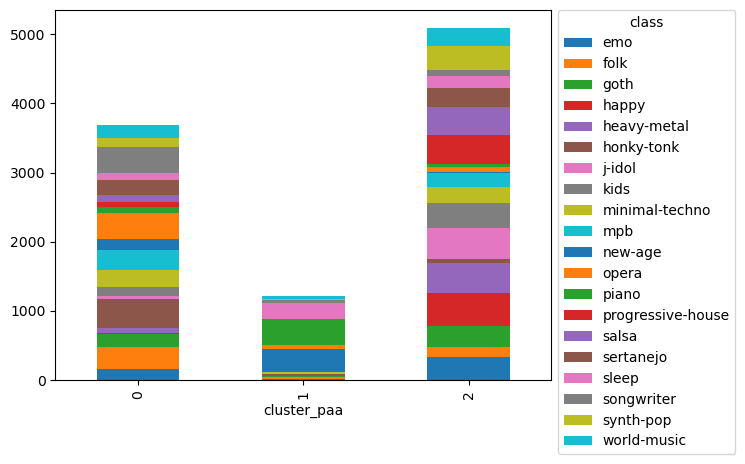

In [31]:
%%time

clusterer = TimeSeriesKMeans(n_clusters=3, metric="dtw")
clusterer.fit(X_paa)

print('Silhouette', silhouette_score(dist_mat_paa, clusterer.labels_, metric='precomputed'))

#my_sse = clusterer.inertia_

df_ts["cluster_paa"] = clusterer.labels_
pd.crosstab(df_ts["cluster_paa"], y).plot(kind="bar", stacked=True)
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', title="class")

(In legend, genres go top to bottom, while on the graph bottom to top)

Happy is almost all in cluster 2, while heavy-metal is almost completely in cluster 6. Also salsa (6). Some genres are mostly in two or three cluster: goth (1, 6, 7), progressive-house (2, 6), for example.

Even if the silhouette is slightly worse than euclidean, the clustering seems less 'mixed'.

In [96]:
centres_dtw = clusterer.cluster_centers_

In [97]:
np.save('clusters_dtw', df_ts["cluster_paa"])
np.save('centres_dtw', centres_dtw)

In [9]:
clusters_dtw = np.load('clusters_dtw.npy')

df_ts["cluster_paa"] = clusters_dtw

centres_dtw = np.load('centres_dtw.npy')

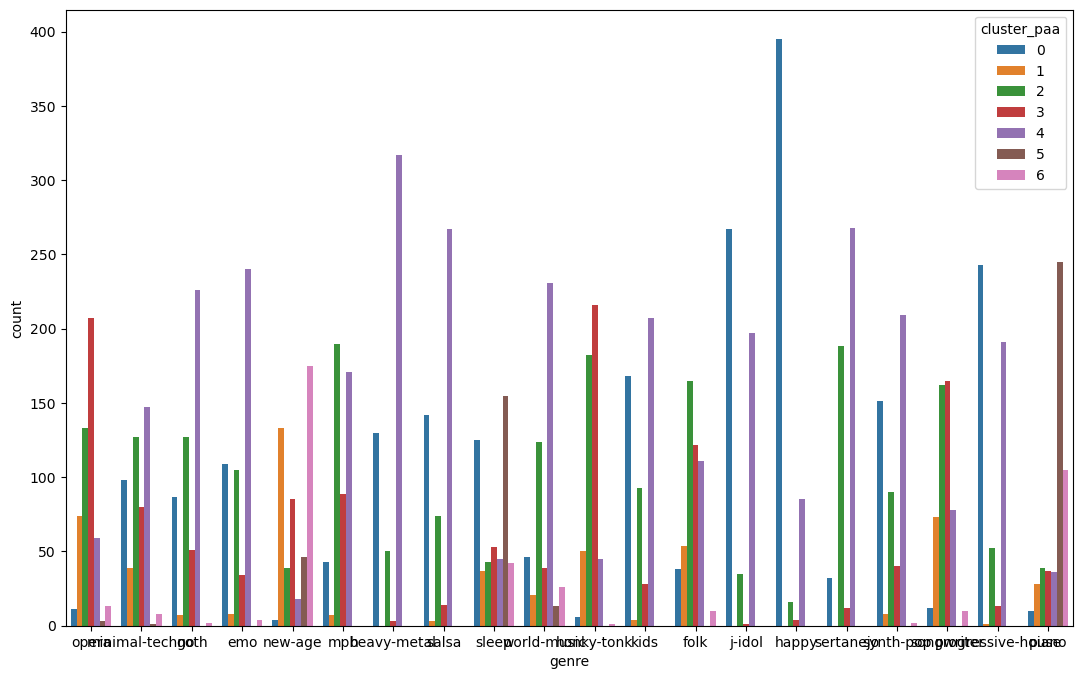

In [98]:
fig = plt.figure(figsize=(13, 8))


sns.countplot(data=df_ts, x='genre', hue='cluster_paa', )
plt.show()

In [99]:
%%time



for i in range(len(centres_dtw)):
    d_cen = np.zeros((len(X_paa)))
    for j in range(len(X_paa)):
        d_cen[j] = distance(centres_dtw[i], X_paa[j], metric='dtw')
    m = min(d_cen)
    print(m)
    print(np.where(d_cen == m))

115025.13215328367
(array([2546]),)
56372.05550496502
(array([7181]),)
201065.8209665594
(array([8012]),)
411429.74525559647
(array([4096]),)
196647.20986385772
(array([2994]),)
30461.223624390925
(array([5828]),)
22030.231032952433
(array([1220]),)
CPU times: user 43min 19s, sys: 1min 10s, total: 44min 30s
Wall time: 44min 45s


In [97]:
medoids = [2546, 7181, 8012, 4096, 2994, 5828, 1220]

%%time

clusterer = TimeSeriesKMeans(n_clusters=8, metric="dtw")
clusterer.fit(X_paa)

my_sse = clusterer.inertia_

N = 20
sse_stats = []

for _ in range(N):
    Xi = np.zeros(shape=np.squeeze(X_paa).shape)
    
    for cidx in range(Xi.shape[1]):
        col = np.squeeze(X_paa)[:, cidx]
        min, max, nor = np.min(col), np.max(col), len(col)
        Xi[:, cidx] = np.random.uniform(min, max, (1, nor))
    
    clusterer = TimeSeriesKMeans(n_clusters=8, n_init=10, max_iter=100, metric="dtw")
    clusterer.fit(Xi)
    sse_stats.append(clusterer.inertia_)

plt.hist(sse_stats, bins='auto')
plt.vlines(x = my_sse, ymin = 0, ymax = 10, colors = 'purple', label = 'my_sse')
plt.xlabel('SSE')
plt.ylabel('Count')
plt.legend()
plt.show()

In [19]:
df_ts.head(5829)

0            1            2            3            4  \
0      768.953928   828.022584   941.386304   945.749554  1159.725465   
1     3230.211119  3344.520081  3136.686050  2845.915331  2808.156723   
2     2192.694219  1986.904857  2082.598864  2254.738538  2401.683572   
3     1050.270174  1122.238261  1176.087855  1132.076020  1099.776970   
4     2467.430056  2222.344861  2053.680022  1733.958104  1115.226422   
...           ...          ...          ...          ...          ...   
5824  2153.422682  2134.825359  2267.301893  2437.534995  2582.155791   
5825  1533.972310  1610.074247  1912.761088  1923.618417  2104.538697   
5826  3047.602134  2992.411529  3146.185278  3628.400413  3645.481167   
5827  2429.085219  2490.514563  2506.922420  2503.771979  2478.811351   
5828   454.974559   587.579030   488.522539   401.589830   426.004955   

                5            6            7            8            9  ...  \
0     1240.333451  1423.674344  1634.191655  1828.503961  1847.519588  ...   
1     2651.146880  2495.342218  2549.019959  2661.295847  2727.635261  ...   
2     2407.616566  2217.455236  2091.153692  1957.757435  1862.646861  ...   
3     1044.397110  1017.142440  1071.410733  1101.055515  1114.730346  ...   
4      821.548505   964.249252  1550.314474  2235.348186  2176.156140  ...   
...           ...          ...          ...          ...          ...  ...   
5824  2532.503253  2401.512339  2462.447484  2679.375467  2747.385265  ...   
5825  2238.126729  2317.801576  2533.879813  2530.282060  2551.438829  ...   
5826  3678.118906  3808.433742  3561.085964  3889.499382  4532.588967  ...   
5827  2416.678952  2406.071406  2401.420104  2414.795157  2380.266029  ...   
5828   414.040696   429.726775   416.259972   385.037530   392.075270  ...   

             1272         1273         1274         1275         1276  \
0     1279.665800  1360.056734  1444.307480  1517.640273  1458.297057   
1     3191.035809  2830.924961  2308.329541  1724.827512  1325.563666   
2     3222.103029  3303.188014  3347.910378  3343.393614  3378.469131   
3      859.559805   802.391176   798.260556   753.313485   770.064609   
4     1417.110211  1939.536578  1798.345901  1245.512644  1079.249670   
...           ...          ...          ...          ...          ...   
5824  2441.577509  2236.098380  2257.027350  2399.581374  2430.420435   
5825  2021.580704  2033.403916  1939.180084  1750.307834  1488.727617   
5826  2677.696287  2385.093817  2371.786623  2479.217219  2709.576462   
5827  1798.447162  1797.020487  1507.554332  1261.945775  1164.890004   
5828   424.949256   418.760570   472.887427   468.978756   427.753994   

             1277         1278         1279           genre  \
0     1442.914786  1391.236018  1321.283908           opera   
1     1130.380398   978.286919   899.698980  minimal-techno   
2     3533.683709  3432.652557  3476.442086            goth   
3      804.954898   839.047077   851.398559           opera   
4     1005.486618   926.054992   964.566937  minimal-techno   
...           ...          ...          ...             ...   
5824  2436.477519  2348.133533  2368.917644            goth   
5825  2224.986224  3010.927863  2633.988515      songwriter   
5826  2983.987790  3162.172081  3292.317980  minimal-techno   
5827  1197.278166  1282.496881  1303.929205           opera   
5828   487.508128   469.999973   433.706255           sleep   

                          id  
0     3HUMNxBQoCPTg2K8wi7oFb  
1     0vgIkHFK8wpogVc1XCi18F  
2     0Av7W8Abdx761b2Ey5wo1u  
3     5KIuAOpwX3UHISVwuBhG2J  
4     1e6YswGTpMvjk21TQAxfXw  
...                      ...  
5824  0yS0XhFaCIq85IYdxfVN76  
5825  3tCexBo7fH5BspYwQ0mr1g  
5826  3kq4M7XbQ6c7yGzwE72VXM  
5827  6vcXtPGqYCgNMJoOIiuxsB  
5828  1KeBXa5MW4dpVEmtk6r83U  

[5829 rows x 1282 columns]

In [173]:
%%time
sse_list = []
sil_list = []


for k in range(2, 30):
    clusterer = TimeSeriesKMeans(n_clusters=k, metric="euclidean")
    clusterer.fit(X_paa)
    sse_list.append(clusterer.inertia_)
    ss = silhouette_score(dist_mat_paa, clusterer.labels_, metric='precomputed')
    sil_list.append(ss)
    print(ss)
    if ss < 0.2:
        break

0.6752159118722603
0.47616324790543324
0.3867585476189029
0.30852705061633817
0.25097805101019605
0.25018508255319805
0.2041420611342549
0.18378492289305448
CPU times: user 4min 17s, sys: 3.18 s, total: 4min 20s
Wall time: 4min 29s


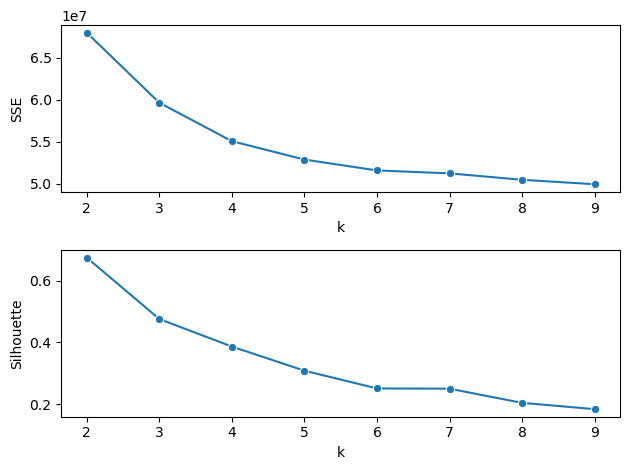

In [174]:
fig, axs = plt.subplots(2) 

sns.lineplot(x=range(2,len(sse_list)+2), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(2, len(sil_list)+2), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots

In [175]:
clusterer = TimeSeriesKMeans(n_clusters=7, n_init=50, metric="euclidean")
clusterer.fit(X_paa)

TimeSeriesKMeans(metric='euclidean', n_clusters=7, n_init=50)

In [176]:
print('Silhouette', silhouette_score(dist_mat_paa, clusterer.labels_, metric='precomputed'))

Silhouette 0.20450147140785008


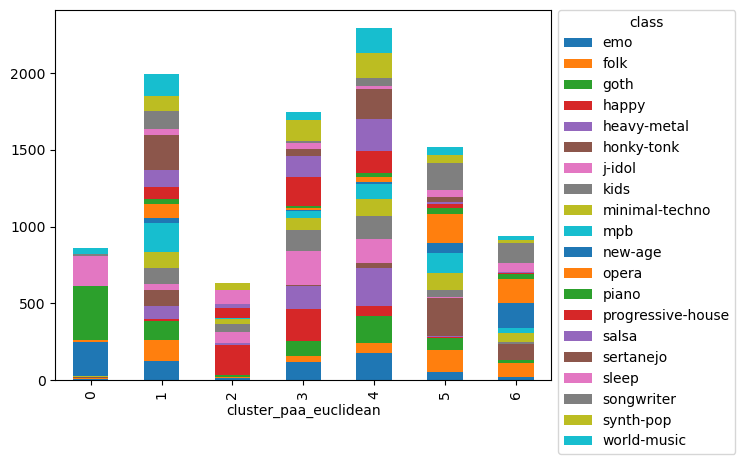

In [105]:
df_ts["cluster_paa_euclidean"] = clusterer.labels_
pd.crosstab(df_ts["cluster_paa_euclidean"], y).plot(kind="bar", stacked=True)
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', title="class")

Slightly better silhouette than dtw, even if it is more mixed (no genres almost completely in one cluster or two).

Much less stable than dtw, since with dtw the silhouette scores and the centroids after each iteration are more similar than the various iterations with euclidean.

In [106]:
centres = clusterer.cluster_centers_

%%time



for i in range(len(centres)):
    d_cen = np.zeros((len(X_paa)))
    for j in range(len(X_paa)):
        d_cen[j] = distance(centres[i], X_paa[j], metric='dtw')
    m = min(d_cen)
    print(m)
    print(np.where(d_cen == m))

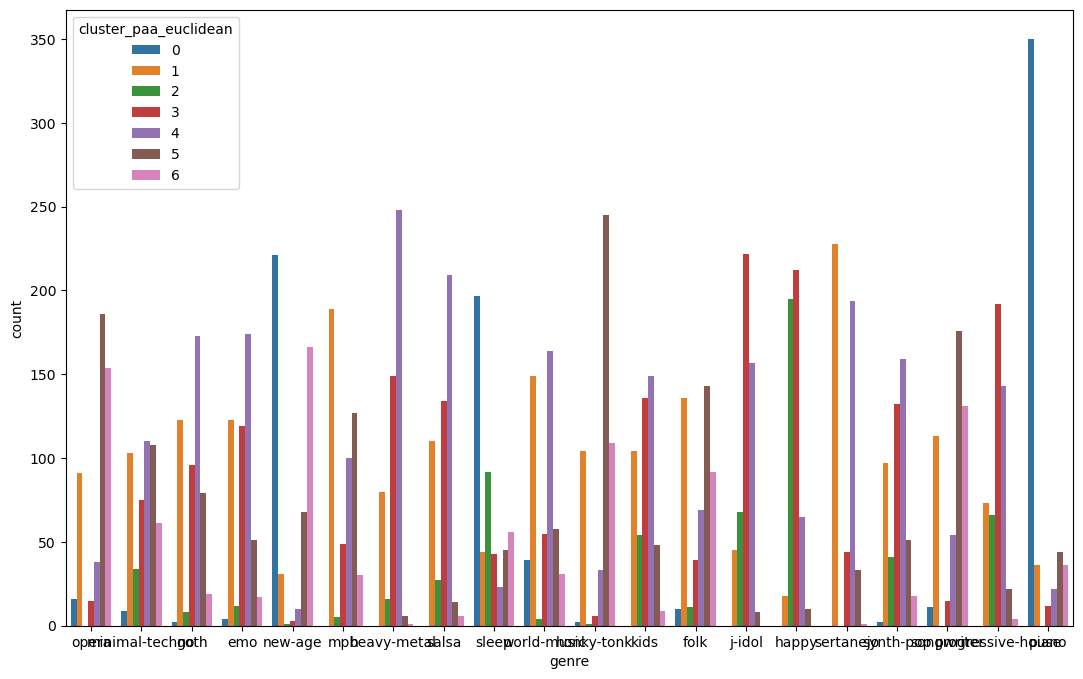

In [115]:
fig = plt.figure(figsize=(13, 8))


sns.countplot(data=df_ts, x='genre', hue='cluster_paa_euclidean', )
plt.show()

In [ ]:
df = pd.read_csv('dfnbpaa.csv')
dfa = np.array(df)

In [ ]:
%%time

dist_paa_ema = np.zeros((100, 100))

for i in range(0,100):
    
    #Definisco array e lo trasformo in interi. Andrò poi a vedere tutti gli array successivi (quindi n-i confronti)
    array = dfa[i,1].split(', ')
    for index in range(len(array)):
        if '[' in array[index]:
            array[index] = array[index].replace('[', "")
        if ']' in array[index]:
            array[index] = array[index].replace(']', "")
        array[index] = int(array[index])
    X_ema = np.transpose(array)
        
    #Definisco il secondo array, che confronto con il primo
    for j in range(i+1,100):
        array2 = dfa[i,1].split(', ')
        for index in range(len(array2)):
            if '[' in array2[index]:
                array2[index] = array2[index].replace('[', "")
            if ']' in array2[index]:
                array2[index] = array2[index].replace(']', "")
            array2[index] = int(array2[index])
            
        X_ema2 = np.transpose(array2)
        
    #Approssimo con PAA secondo n_beats
        if int(dfa[i,3]) < 1280:
            if dfa[i,3] == 0.0: 
                paa_ema = PAA(128)
                array_paa = paa_ema.fit_transform(X_ema)
            else:
                paa_ema = PAA(int(dfa[i,3]))
                array_paa = paa_ema.fit_transform(X_ema)
        else: array_paa = X_ema
        if int(dfa[j,3]) < 1280:
            if dfa[j,3] == 0.0: 
                paa_ema = PAA(128)
                array_paa = paa_ema.fit_transform(X_ema)
            else:
                paa2_ema = PAA(int(dfa[j,3]))
                array2_paa = paa2_ema.fit_transform(X_ema2)
        else: array2_paa = X_ema2
        
    #Salvo la distanza su una matrice
        dist_paa_ema[i,j] = distance(array_paa, array2_paa, metric="dtw")
        dist_paa_ema[j,i] = distance(array_paa, array2_paa, metric="dtw")


%%time

list_ema = []


for i in range(0,10000):
    array = dfa[i,1].split(', ')
    for index in range(len(array)):
        if '[' in array[index]:
            #array[index] = array[index][1:]
            array[index] = array[index].replace('[', "")
        if ']' in array[index]:
            #array[index] = array[index][:3]
            array[index] = array[index].replace(']', "")
        array[index] = int(array[index])
    X_ema = np.transpose(array)
    
    list_ema.append(X_ema)
    
df_ema = pd.DataFrame(list_ema)
array_ema = np.array(df_ema)

for i in range(0,10000):
    for j in range(0,1279):
        if math.isnan(array_ema[i,j]) == True:
            array_ema[i,j] = array_ema[i,j-1]

## Motifs and anomalies on centroids

In [21]:
df_centroids = np.transpose(pd.DataFrame(np.squeeze(centres_dtw)))

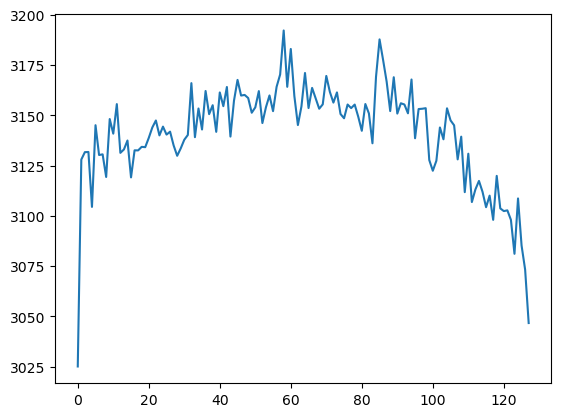

In [22]:
plt.plot(np.transpose(pd.DataFrame(np.squeeze(centres_dtw)))[3])
plt.show()

In [98]:
X_med = np.transpose(pd.DataFrame(np.squeeze(X)))

In [99]:
w = 12 #window
mp, mpi = matrixProfile.stomp(X_med[medoids[1]].values, w) #mp = matrix profile, mpi = matrix profile indeces

### Motifs

for i in range(4,13):
    w = i
    mp, mpi = matrixProfile.stomp(X_med[8422].values, w)
    mo, mod  = motifs.motifs(X_med[8422].values, (mp, mpi))
    print(i, '=> Number of motifs: ', len(mo))
    for j in range(len(mo)):
        print('          ', len(mo[j]), '; ')

for i in range(4,13):
    w = i
    mp, mpi = matrixProfile.stomp(X_med[2546].values, w)
    mo, mod  = motifs.motifs(X_med[2546].values, (mp, mpi))
    print(i, '=> Number of motifs: ', len(mo))
    for j in range(len(mo)):
        print('          ', len(mo[j]), '; ')

In [100]:
mo, mod  = motifs.motifs(X_med[medoids[1]].values, (mp, mpi))

In [101]:
mo

[[287, 336, 536], [601, 665, 997, 1050], [202, 560, 733, 921, 1075, 1101]]

In [102]:
mod

[0.7435034975114786, 0.9510834012499119, 1.081456005431392]

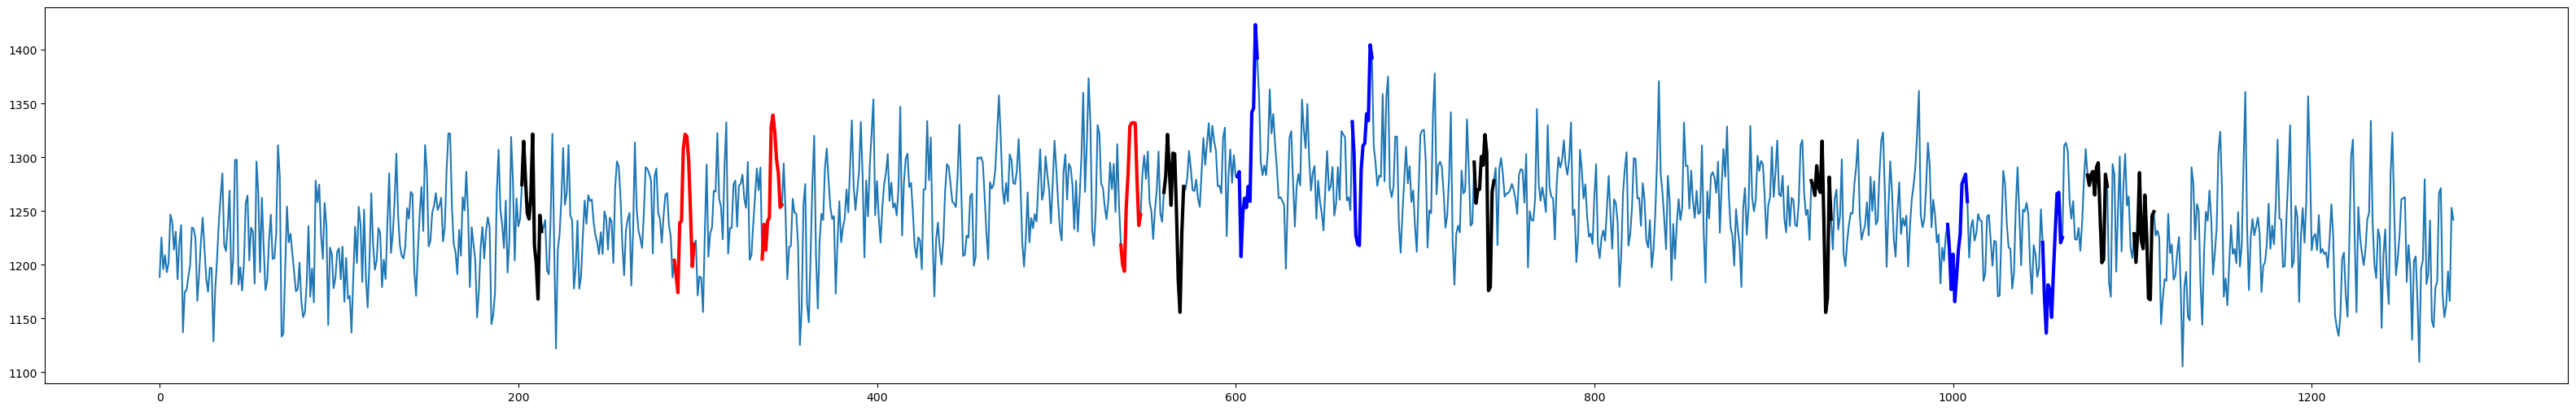

In [103]:
fig = plt.figure(figsize=(40, 6))

plt.plot(X_med[medoids[1]].values)
colors = ['r', 'b', 'k', 'g', 'y'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
    for i in m:
        m_shape = X_med[medoids[1]].values[i:i+w]
        plt.plot(range(i,i+w), m_shape, color=c, lw=3)

plt.show()

##### DA FAR NOTARE!!!!
The last discord on the right of the X_med[2546] with w=6 has an overlap with a motif. 

In [149]:
help(motifs.motifs)

Help on function motifs in module matrixprofile.motifs:

motifs(ts, mp, max_motifs=3, radius=2, n_neighbors=None, ex_zone=None)
    Computes the top k motifs from a matrix profile
    
    Parameters
    ----------
    ts: time series to used to calculate mp
    mp: tuple, (matrix profile numpy array, matrix profile indices)
    max_motifs: the maximum number of motifs to discover
    ex_zone: the number of samples to exclude and set to Inf on either side of a found motifs
        defaults to m/2
    
    Returns tuple (motifs, distances)
    motifs: a list of lists of indexes representing the motif starting locations.
    distances: list of minimum distances for each motif



### Anomalies

In [104]:
anoms = discords(mp, ex_zone=3, k=3)

In [105]:
anoms

array([ 93, 903,  47])

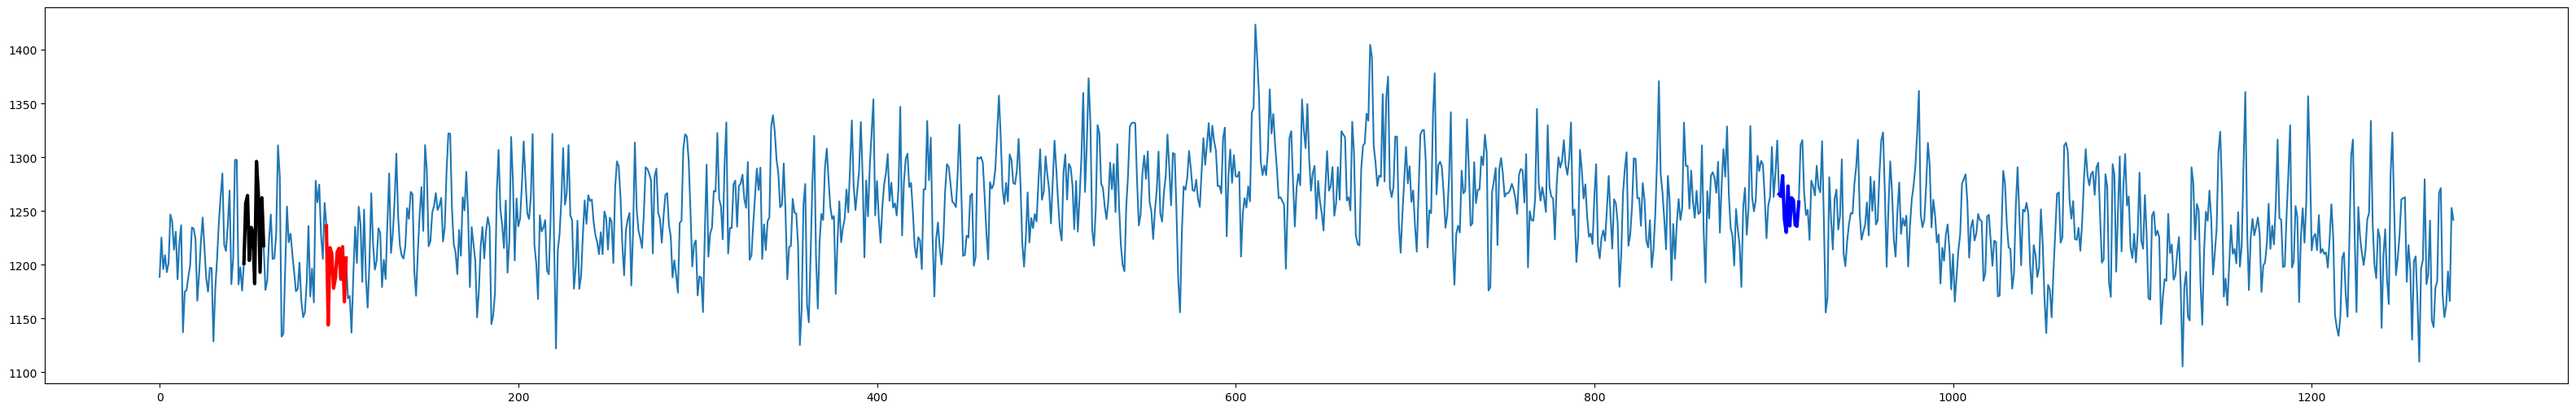

In [106]:
fig = plt.figure(figsize=(40, 6))

plt.plot(X_med[medoids[1]].values)
colors = ['r', 'b', 'k', 'g', 'y'][:len(anoms)]
for a, c in zip(anoms, colors):
    a_shape = X_med[medoids[1]].values[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)

plt.show()

For X_med[2546], the anomalies are basically the same for w=7 and w=8 (in the same starting spots), but are different for w=6

In [32]:
help(discords)

Help on function discords in module matrixprofile.discords:

discords(mp, ex_zone, k=3)
    Computes the top k discords from a matrix profile
    
    Parameters
    ----------
    mp: matrix profile numpy array
    k: the number of discords to discover
    ex_zone: the number of samples to exclude and set to Inf on either side of a found discord
    
    Returns a list of indexes represent the discord starting locations. MaxInt indicates there
    were no more discords that could be found due to too many exclusions or profile being too
    small. Discord start indices are sorted by highest matrix profile value.



## Motifs and anomalies on elements closer to centroids

Just copy and paste the previous chapter

## GSP

%%time

###### Running GSP without time constraints

gsp = GSP(ds=X_paa, minsup=0.001)
patterns = gsp.run_gsp()
patterns

%%time

###### Running GSP with time constraints

gsp = GSP(ds=X_paa, minsup=0.0003, mingap=1, maxgap=2, maxspan=3)
patterns = gsp.run_gsp()
patterns

## Dimensionality Reduction

In [ ]:
genre_map={'emo':0, 'folk':1, 'goth':2, 'happy':3, 'progressive-house':4, 'sertanejo':5, 'piano':6, 'heavy-metal':7, 'honky-tonk':8, 'j-idol':9, 'kids':10, 'minimal-techno':11, 'mpb':12, 'new-age':13,'opera':14, 'salsa':15, 'sleep':16, 'songwriter':17,'synth-pop':18, 'world-music':19}

y_mapped = pd.DataFrame(y).replace(genre_map)

In [56]:
color_map={7:'k', 1:'g', 2:'r', 3:'b', 4:'y', 5:'c', 6:'m', 0:'w'}


y_mapped = df_ts['cluster_paa'].replace(color_map)
#y_mapped_euc = df_ts['cluster_paa_euclidean'].replace(color_map)

### PCA

In [55]:
pca = PCA(n_components=2)
pca.fit(np.squeeze(X))
X_pca = pca.transform(np.squeeze(X))

/var/folders/g7/2_x1m4492lxbbvl9rf481czc0000gn/T/ipykernel_6060/2072177881.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mapped,


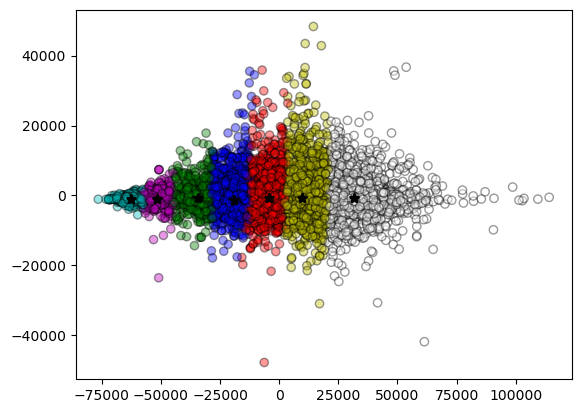

In [130]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mapped,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.4, linewidths=1)
plt.scatter(X_pca[medoids, 0], X_pca[medoids, 1], marker='*',
            edgecolor='k', alpha=1, linewidths=2)
plt.show()

/var/folders/g7/2_x1m4492lxbbvl9rf481czc0000gn/T/ipykernel_6060/4022403328.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mapped_euc,


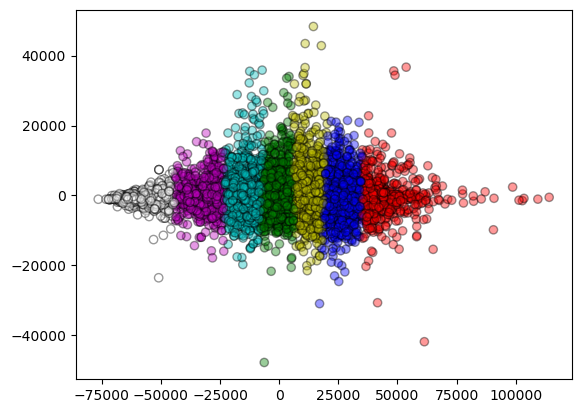

In [131]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mapped_euc,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.4, linewidths=1)
plt.show()

### IsoMap

In [62]:
iso = Isomap(n_components=2)
X_iso = iso.fit_transform(np.squeeze(X))

/var/folders/g7/2_x1m4492lxbbvl9rf481czc0000gn/T/ipykernel_6060/210143830.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_iso[:, 0], X_iso[:, 1], c=y_mapped,


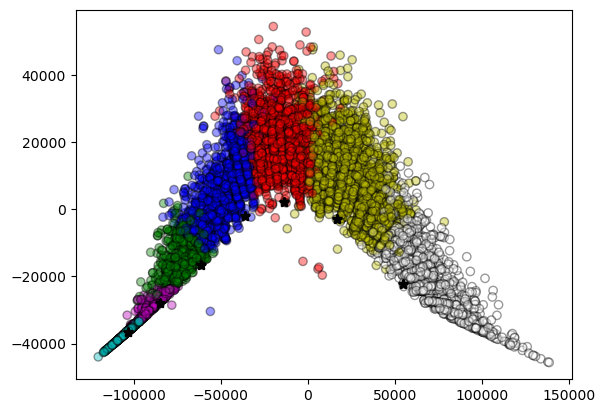

In [132]:
plt.scatter(X_iso[:, 0], X_iso[:, 1], c=y_mapped,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.4, linewidths=1)
plt.scatter(X_iso[medoids, 0], X_iso[medoids, 1], marker='*',
            edgecolor='k', alpha=1, linewidths=2)
plt.show()

/var/folders/g7/2_x1m4492lxbbvl9rf481czc0000gn/T/ipykernel_6060/2811951901.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_iso[:, 0], X_iso[:, 1], c=y_mapped_euc,


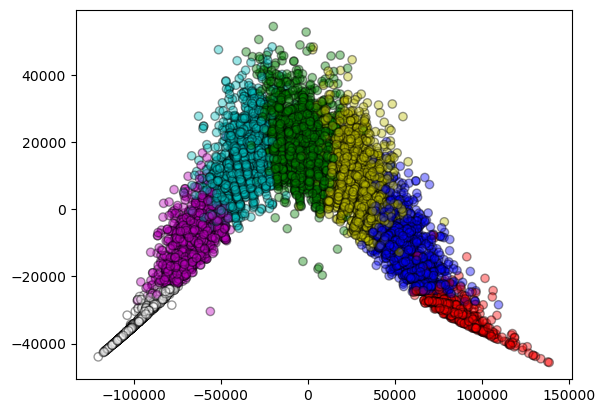

In [133]:
plt.scatter(X_iso[:, 0], X_iso[:, 1], c=y_mapped_euc,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.4, linewidths=1)
plt.show()

### t-SNE

In [63]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(np.squeeze(X))

/var/folders/g7/2_x1m4492lxbbvl9rf481czc0000gn/T/ipykernel_6060/987795593.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_mapped,


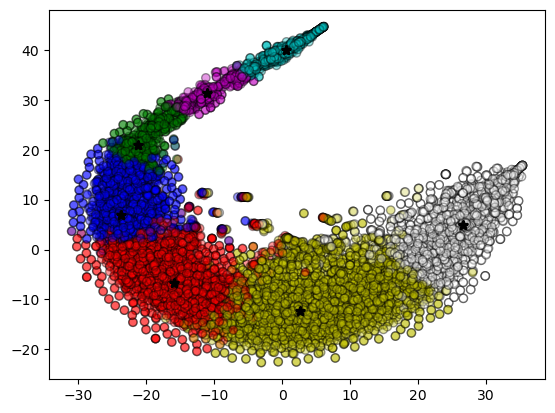

In [137]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_mapped,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.4, linewidths=1)

plt.scatter(X_tsne[medoids, 0], X_tsne[medoids, 1], marker='*',
            edgecolor='k', alpha=1, linewidths=2)

plt.show()

/var/folders/g7/2_x1m4492lxbbvl9rf481czc0000gn/T/ipykernel_6060/393701125.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_mapped_euc,


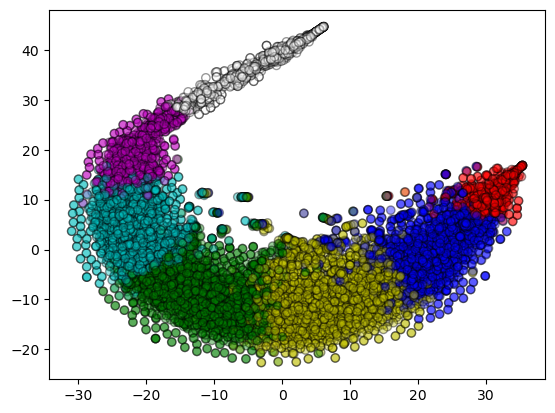

In [135]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_mapped_euc,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.4, linewidths=1)
plt.show()

## Feature Based Clustering

In [9]:
transformer = SummaryTransformer(summary_function=('mean', 'min', 'max', 'median', 'std'))

In [10]:
%%time

F_train = transformer.fit_transform(X)
F_train

CPU times: user 1min 10s, sys: 3.86 s, total: 1min 14s
Wall time: 1min 22s


mean          min          max       median          std  \
instances                                                                    
0          1658.266862   664.281001  4294.587234  1705.743998   546.081541   
1          1669.254222   572.195995  4495.593766  1454.999030   781.239096   
2          2275.563402  1032.166763  4952.423202  2174.191941   560.781903   
3          1373.101158   585.541834  2099.020247  1376.659276   291.911407   
4          1677.731838   433.130687  4204.552974  1615.922243   657.848982   
...                ...          ...          ...          ...          ...   
9995       2865.031474  2330.561473  4031.466612  2848.507875   196.226466   
9996       2424.652610   924.607642  5077.861340  2396.486624   593.942815   
9997       2807.977765   170.201028  6206.808889  2809.585702  1108.993112   
9998       2909.581274   286.651184  7042.463305  2807.130513  1277.545706   
9999       2302.011002   935.906710  5542.094560  2282.525828   615.508099   

                   0.1         0.25          0.5         0.75          0.9  
instances                                                                   
0           936.291752  1216.487647  1705.743998  2017.645577  2188.327351  
1           824.377271  1038.218661  1454.999030  2204.715317  2824.541890  
2          1666.504309  1944.966265  2174.191941  2537.964940  2950.797439  
3           973.473765  1136.339645  1376.659276  1611.195935  1743.512440  
4           875.517970  1170.116290  1615.922243  2124.239824  2566.467309  
...                ...          ...          ...          ...          ...  
9995       2635.314377  2742.304977  2848.507875  2978.519231  3084.109559  
9996       1716.908331  2070.207746  2396.486624  2710.449607  3009.571398  
9997       1374.311797  2208.333441  2809.585702  3473.206748  4027.800450  
9998       1442.937004  1916.001806  2807.130513  3675.685844  4592.425634  
9999       1566.809758  1882.958027  2282.525828  2639.340303  3003.432786  

[10000 rows x 10 columns]

In [26]:
#Normalization

scaler =  MinMaxScaler()
scaler.fit(F_train)
F_train_norm = scaler.transform(F_train)

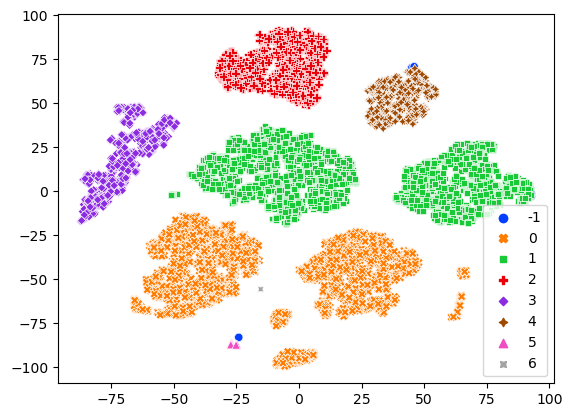

CPU times: user 1min 47s, sys: 1.83 s, total: 1min 48s
Wall time: 56.7 s


In [27]:
%%time

clusterer_f = DBSCAN(eps=0.25, min_samples=10)
clusterer_f.fit(F_train_norm)
F_train["cluster"] = clusterer_f.labels_

tsnef = TSNE(n_components=2)
F_tsne = tsnef.fit_transform(F_train_norm)


sns.scatterplot(data=F_tsne, 
                x=F_tsne[:, 0],
                y=F_tsne[:, 1], 
                hue=clusterer_f.labels_, 
                style=clusterer_f.labels_, 
                palette="bright")

plt.show()

In [25]:
F_train[F_train["cluster"]==1].count()

mean         101
min          101
max          101
median       101
std          101
0.1          101
0.25         101
0.5          101
0.75         101
0.9          101
cluster      101
cluster_k    101
dtype: int64

With min_samples = 10:

For eps >= 2.5, everything gets clustered in one big cluster.

For eps =0.75, there are 4 clusters, one with 7440 elements, one with 2156, one with 22 and one with 16, with 366 outliers.

For eps = 1, there are 4 clusters, one with 7440 elements, one with 2431, one with 22 and one with 16, with 91 outliers.

For eps <= 0.5, there are different clusters, but one is very big (7417 elements), while the others are very very small, and are a lot (more than 20 other clusters), also because there are 2105 outliers.

<timed exec>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


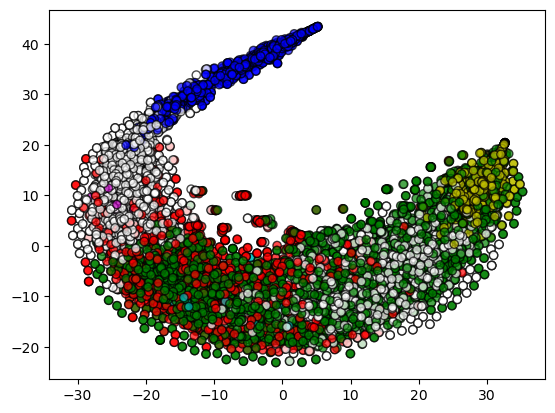

CPU times: user 2min 46s, sys: 1.99 s, total: 2min 48s
Wall time: 1min 25s


In [31]:
%%time

df_ts["cluster_f"] = clusterer_f.labels_

tsnef = TSNE(n_components=2)
Xf_tsne = tsnef.fit_transform(np.squeeze(X))

color_map={-1:'k', 1:'g', 2:'r', 3:'b', 4:'y', 5:'c', 6:'m', 0:'w'}


y_mapped_f = df_ts['cluster_f'].replace(color_map)

plt.scatter(Xf_tsne[:, 0], Xf_tsne[:, 1], c=y_mapped_f,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [38]:
print('Silhouette', silhouette_score(F_train_norm, F_train['cluster']))
print('Silhouette', silhouette_score(dist_mat_paa, F_train['cluster'], metric='precomputed'))

Silhouette 0.4078017157505483
Silhouette -0.2915239925956472


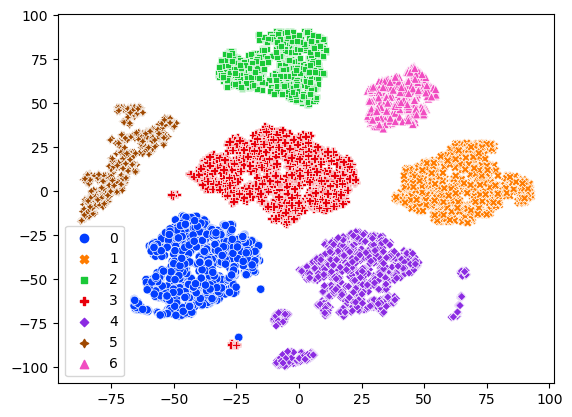

CPU times: user 1min 46s, sys: 1.89 s, total: 1min 48s
Wall time: 56.2 s


In [32]:
%%time

clusterer_fk = KMeans(n_clusters=7, n_init=10, max_iter=100, random_state=94)
clusterer_fk.fit(F_train_norm)
F_train["cluster_k"] = clusterer_fk.labels_


tsnef = TSNE(n_components=2)
F_tsne = tsnef.fit_transform(F_train_norm)


sns.scatterplot(data=F_tsne, 
                x=F_tsne[:, 0],
                y=F_tsne[:, 1], 
                hue=clusterer_fk.labels_, 
                style=clusterer_fk.labels_, 
                palette="bright")

plt.show()

<timed exec>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


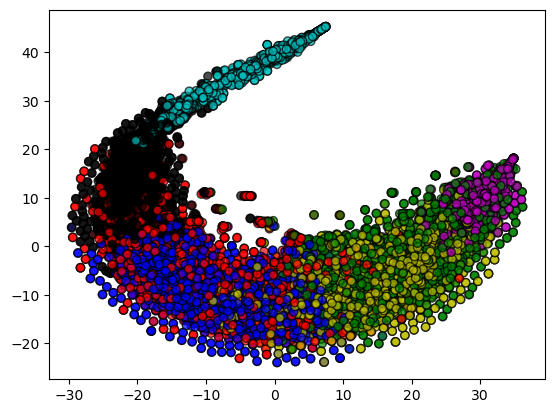

CPU times: user 3min 31s, sys: 2.6 s, total: 3min 33s
Wall time: 1min 51s


In [33]:
%%time

df_ts["cluster_fk"] = clusterer_fk.labels_

tsnef = TSNE(n_components=2)
Xf_tsne = tsnef.fit_transform(np.squeeze(X))

color_map={0:'k', 1:'g', 2:'r', 3:'b', 4:'y', 5:'c', 6:'m', 7:'w'}


y_mapped_fk = df_ts['cluster_fk'].replace(color_map)

plt.scatter(Xf_tsne[:, 0], Xf_tsne[:, 1], c=y_mapped_fk,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [34]:
print('Silhouette', silhouette_score(F_train_norm, df_ts['cluster_fk']))
print('Silhouette', silhouette_score(dist_mat_paa, df_ts['cluster_fk'], metric='precomputed'))

Silhouette 0.5142741000548826
Silhouette 0.2257100242491706


In [35]:
sil_feats = np.zeros(18)
sil_ts = np.zeros(18)

for i in range(2,20):
    clusterer_fk = KMeans(n_clusters=i, n_init=10, max_iter=100, random_state=94)
    clusterer_fk.fit(F_train_norm)
    sil_feats[i-2] = silhouette_score(F_train_norm, clusterer_fk.labels_)
    sil_ts[i-2] = silhouette_score(dist_mat_paa, clusterer_fk.labels_, metric='precomputed')

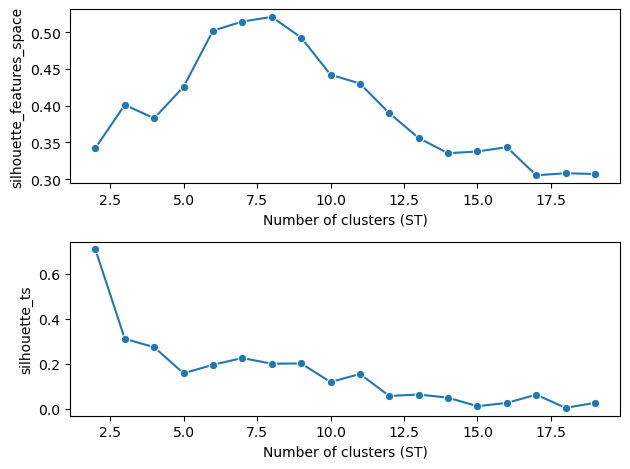

In [36]:
fig, axs = plt.subplots(2) 

sns.lineplot(x=range(2,len(sil_feats)+2), y=sil_feats, marker='o', ax=axs[0])
axs[0].set(xlabel='Number of clusters (ST)', ylabel='silhouette_features_space')

sns.lineplot(x=range(2, len(sil_ts)+2), y=sil_ts, marker='o', ax=axs[1])
axs[1].set(xlabel='Number of clusters (ST)', ylabel='silhouette_ts')

plt.tight_layout() # Adjust the padding between and around subplots

In [39]:
ts_eff = TSFreshFeatureExtractor(default_fc_parameters="comprehensive", show_warnings=False,
                                 disable_progressbar=False) 

In [40]:
%time

X_transform1 = ts_eff.fit_transform(X)
X_transform1

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


Feature Extraction: 100%|███████████████| 10000/10000 [4:06:25<00:00,  1.48s/it]


var_0__variance_larger_than_standard_deviation  \
0                                                1.0   
1                                                1.0   
2                                                1.0   
3                                                1.0   
4                                                1.0   
...                                              ...   
9995                                             1.0   
9996                                             1.0   
9997                                             1.0   
9998                                             1.0   
9999                                             1.0   

      var_0__has_duplicate_max  var_0__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
9995                       0.0                       0.0   
9996                       0.0                       0.0   
9997                       0.0                       0.0   
9998                       0.0                       0.0   
9999                       0.0                       0.0   

      var_0__has_duplicate  var_0__sum_values  var_0__abs_energy  \
0                      0.0       2.122582e+06       3.901211e+09   
1                      0.0       2.136645e+06       4.347222e+09   
2                      0.0       2.912721e+06       7.030297e+09   
3                      0.0       1.757569e+06       2.522307e+09   
4                      0.0       2.147497e+06       4.156430e+09   
...                    ...                ...                ...   
9995                   0.0       3.667240e+06       1.055601e+10   
9996                   0.0       3.103555e+06       7.976234e+09   
9997                   0.0       3.594212e+06       1.166546e+10   
9998                   0.0       3.724264e+06       1.292353e+10   
9999                   0.0       2.946574e+06       7.267595e+09   

      var_0__mean_abs_change  var_0__mean_change  \
0                  68.077808            0.431845   
1                 318.460520           -1.822136   
2                 152.658047            1.003712   
3                  42.442397           -0.155490   
4                 351.890152           -1.175030   
...                      ...                 ...   
9995              117.809033            0.048038   
9996              205.121979           -0.147306   
9997              285.687899            0.854372   
9998              380.097061           -0.496303   
9999              304.294761            1.167519   

      var_0__mean_second_derivative_central  var_0__median  ...  \
0                                 -0.050478    1705.743998  ...   
1                                 -0.075468    1454.999030  ...   
2                                  0.097644    2174.191941  ...   
3                                 -0.023324    1376.659276  ...   
4                                  0.110953    1615.922243  ...   
...                                     ...            ...  ...   
9995                              -0.046733    2848.507875  ...   
9996                              -0.061876    2396.486624  ...   
9997                               0.071410    2809.585702  ...   
9998                               0.053355    2807.130513  ...   
9999                               0.126434    2282.525828  ...   

      var_0__fourier_entropy__bins_5  var_0__fourier_entropy__bins_10  \
0                           0.307703                         0.532447   
1                           0.090729                         0.300740   
2                           0.560821                         0.860216   
3                           0.090729                         0.200814   


In [41]:
#Normalization

scaler = MinMaxScaler()
scaler.fit(X_transform1)
X_transform_norm = scaler.transform(X_transform1)

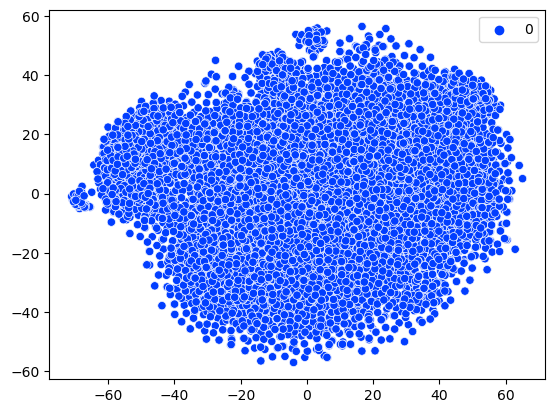

CPU times: user 2min 20s, sys: 3.7 s, total: 2min 24s
Wall time: 1min 13s


In [42]:
%%time

clusterer_fts = DBSCAN(eps=25, min_samples=10)
clusterer_fts.fit(X_transform_norm)
#F_train["cluster_fresh"] = clusterer_fts.labels_

tsnef = TSNE(n_components=2)
X_tsnef = tsnef.fit_transform(X_transform_norm)

sns.scatterplot(data=X_tsnef, 
                x=X_tsnef[:, 0],
                y=X_tsnef[:, 1], 
                hue=clusterer_fts.labels_, 
                style=clusterer_fts.labels_, 
                palette="bright")

plt.show()

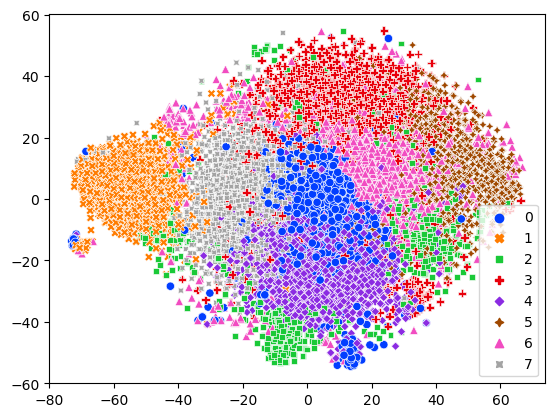

CPU times: user 2min 38s, sys: 1.92 s, total: 2min 39s
Wall time: 1min 20s


In [43]:
%%time

clusterer_ftsk = KMeans(n_clusters=8, n_init=10, max_iter=100, random_state=94)
clusterer_ftsk.fit(X_transform_norm)
#F_train["cluster_k"] = clusterer_ftsk.labels_


tsnef = TSNE(n_components=2)
X_tsnef = tsnef.fit_transform(X_transform_norm)


sns.scatterplot(data=X_tsnef, 
                x=X_tsnef[:, 0],
                y=X_tsnef[:, 1], 
                hue=clusterer_ftsk.labels_, 
                style=clusterer_ftsk.labels_, 
                palette="bright")

plt.show()

<timed exec>:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


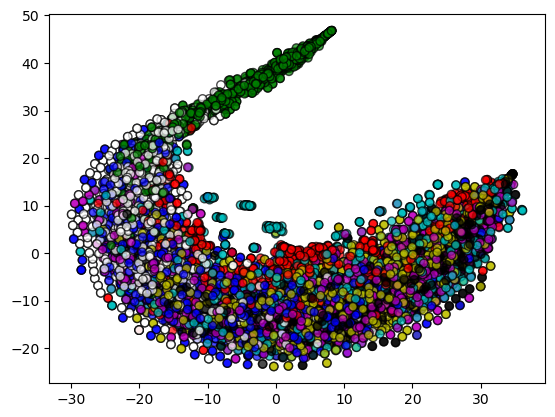

CPU times: user 3min 18s, sys: 3.91 s, total: 3min 22s
Wall time: 1min 43s


In [44]:
%%time

df_ts["cluster_ftsk"] = clusterer_ftsk.labels_

tsnefts = TSNE(n_components=2)
Xfts_tsne = tsnefts.fit_transform(np.squeeze(X))

color_map={0:'k', 1:'g', 2:'r', 3:'b', 4:'y', 5:'c', 6:'m', 7:'w'}


y_mapped_ftsk = df_ts['cluster_ftsk'].replace(color_map)

plt.scatter(Xfts_tsne[:, 0], Xfts_tsne[:, 1], c=y_mapped_ftsk,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

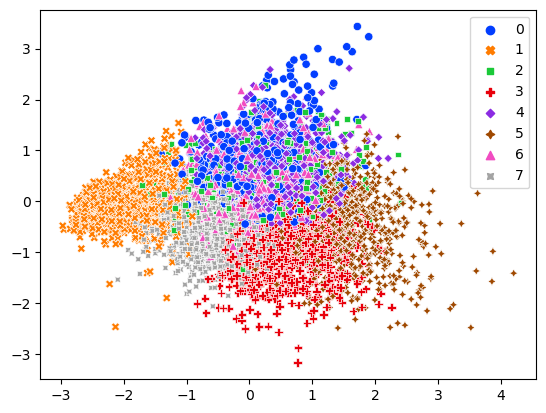

In [45]:
pcaf = PCA(n_components=2)
X_pcaf = pcaf.fit_transform(X_transform_norm)


sns.scatterplot(data=X_pcaf, 
                x=X_pcaf[:, 0],
                y=X_pcaf[:, 1], 
                hue=clusterer_ftsk.labels_, 
                style=clusterer_ftsk.labels_, 
                palette="bright")

plt.show()

/var/folders/g7/2_x1m4492lxbbvl9rf481czc0000gn/T/ipykernel_19425/2105179901.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Xfts_pca[:, 0], Xfts_pca[:, 1], c=y_mapped_fpca,


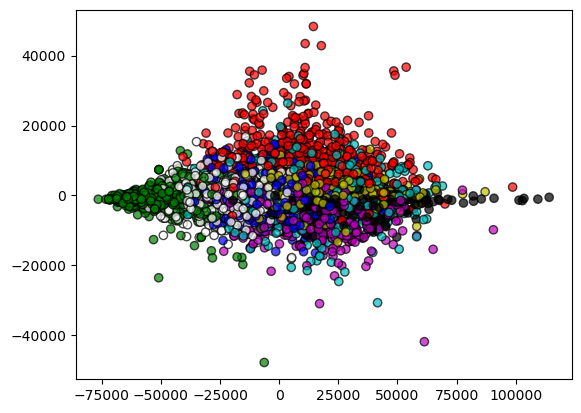

In [46]:
pcafts = PCA(n_components=2)
Xfts_pca = pcafts.fit_transform(np.squeeze(X))

color_map={0:'k', 1:'g', 2:'r', 3:'b', 4:'y', 5:'c', 6:'m', 7:'w'}


y_mapped_fpca = df_ts['cluster_ftsk'].replace(color_map)

plt.scatter(Xfts_pca[:, 0], Xfts_pca[:, 1], c=y_mapped_fpca,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [47]:
for i in range(2,20):
    clusterer_ftsk = KMeans(n_clusters=i, n_init=10, max_iter=100, random_state=13)
    clusterer_ftsk.fit(X_transform_norm)
    print('Silhouette', silhouette_score(X_transform_norm, clusterer_ftsk.labels_))

Silhouette 0.05621172352915055
Silhouette 0.04370754365556902
Silhouette 0.032878067096411646
Silhouette 0.02884680836919747
Silhouette 0.027450459955120108
Silhouette 0.02498375762747271
Silhouette 0.020782919324619845
Silhouette 0.017269059444583384
Silhouette 0.014546055996874788
Silhouette 0.016901516102237182
Silhouette 0.015981335311148946
Silhouette 0.013492940893243807
Silhouette 0.013889828065104325
Silhouette 0.014004117182314155
Silhouette 0.015311175879654667
Silhouette 0.012928169527853155
Silhouette 0.012759085865530923
Silhouette 0.012888703308868458


In [48]:
print('Silhouette', silhouette_score(dist_mat_paa, clusterer_ftsk.labels_, metric='precomputed'))

Silhouette -0.1249849564368812


In [49]:
sil_feats_tsf = np.zeros(18)
sil_ts_tsf = np.zeros(18)

for i in range(2,20):
    clusterer_ftsk = KMeans(n_clusters=i, n_init=10, max_iter=100, random_state=11)
    clusterer_ftsk.fit(X_transform_norm)
    sil_feats_tsf[i-2] = silhouette_score(X_transform_norm, clusterer_ftsk.labels_)
    sil_ts_tsf[i-2] = silhouette_score(dist_mat_paa, clusterer_ftsk.labels_, metric='precomputed')

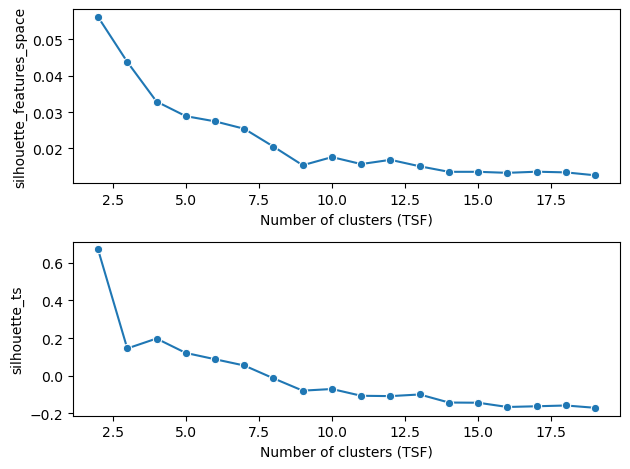

In [50]:
fig, axs = plt.subplots(2) 

sns.lineplot(x=range(2,len(sil_feats_tsf)+2), y=sil_feats_tsf, marker='o', ax=axs[0])
axs[0].set(xlabel='Number of clusters (TSF)', ylabel='silhouette_features_space')

sns.lineplot(x=range(2, len(sil_ts_tsf)+2), y=sil_ts_tsf, marker='o', ax=axs[1])
axs[1].set(xlabel='Number of clusters (TSF)', ylabel='silhouette_ts')

plt.tight_layout() # Adjust the padding between and around subplots

## Merged Clustering

In [10]:
df = pd.read_csv('dataset/tabular/tracks.csv')

In [11]:
to_drop = ['disc_number', 'track_number', 'album_type', 'album_name', 
          'album_total_tracks', 'key', 'mode', 'time_signature', 'liveness', 'start_of_fade_out', 
          'album_release_date', 'album_release_date_precision', 'key_confidence', 'time_signature_confidence', 
           'mode_confidence', 'tempo_confidence', 'name', 'explicit', 'artists', 'genre', 
          'n_beats', 'n_bars', 'features_duration_ms']

df_dropped = df.drop(to_drop, axis=1)

df_dropped = df_dropped.drop_duplicates(subset=['id'])

In [12]:
%%time

list_merged_clust = []

for id_number in df_ts['id']:
    list_merged_clust.append(df_dropped[df_dropped['id'] == id_number])

CPU times: user 1min 2s, sys: 307 ms, total: 1min 2s
Wall time: 1min 3s


In [13]:
df_merge_clust = pd.DataFrame(np.array(np.squeeze(list_merged_clust)))

In [14]:
df_merge_clust = df_merge_clust.drop(0, axis=1)

In [15]:
#Normalization

scaler = MinMaxScaler()
scaler.fit(df_merge_clust)
df_norm = scaler.transform(df_merge_clust)

In [16]:
%%time

dist_mat_attr = np.zeros((len(df_merge_clust),len(df_merge_clust)))

for i in range(len(df_merge_clust)):
    for j in range(i+1, len(df_merge_clust)):
        dist_mat_attr[i,j] = distance(df_norm[i], df_norm[j], metric="euclidean")
        dist_mat_attr[j,i] = dist_mat_attr[i,j]

dist_mat_attr

CPU times: user 10min 10s, sys: 21.4 s, total: 10min 32s
Wall time: 10min 20s


array([[0.        , 1.40909065, 1.06342331, ..., 1.33819811, 1.25150333,
        1.05509876],
       [1.40909065, 0.        , 0.89342467, ..., 1.03738076, 0.9435159 ,
        1.28543281],
       [1.06342331, 0.89342467, 0.        , ..., 0.54170499, 0.4923175 ,
        0.83270509],
       ...,
       [1.33819811, 1.03738076, 0.54170499, ..., 0.        , 0.45289906,
        0.92974997],
       [1.25150333, 0.9435159 , 0.4923175 , ..., 0.45289906, 0.        ,
        0.77147488],
       [1.05509876, 1.28543281, 0.83270509, ..., 0.92974997, 0.77147488,
        0.        ]])

In [74]:
dist_mat_tot = 0.000002*dist_mat_paa + dist_mat_attr
dist_mat_tot

array([[  0.        ,  38.82539578,  56.11887019, ..., 231.05245339,
        180.39516585,  80.43128742],
       [ 38.82539578,   0.        ,  59.18325924, ..., 214.7087374 ,
        151.44715701,  69.78492873],
       [ 56.11887019,  59.18325924,   0.        , ..., 106.2284994 ,
        107.96316806,  26.69557268],
       ...,
       [231.05245339, 214.7087374 , 106.2284994 , ...,   0.        ,
        113.89876556, 138.30701392],
       [180.39516585, 151.44715701, 107.96316806, ..., 113.89876556,
          0.        ,  89.46383763],
       [ 80.43128742,  69.78492873,  26.69557268, ..., 138.30701392,
         89.46383763,   0.        ]])

In [17]:
#Normalization

scaler = MinMaxScaler()
scaler.fit(dist_mat_paa)
dist_mat_paa_norm = scaler.transform(dist_mat_paa)

In [24]:
#Normalization

scaler = MinMaxScaler()
scaler.fit(dist_mat_attr)
dist_mat_attr_norm = scaler.transform(dist_mat_attr)

In [25]:
dist_mat_tot_norm = dist_mat_paa_norm + dist_mat_attr_norm
dist_mat_tot_norm

array([[0.        , 0.80636645, 0.62918956, ..., 0.77584014, 0.70085064,
        0.58358937],
       [0.79263514, 0.        , 0.53344161, ..., 0.61788114, 0.53535676,
        0.70009567],
       [0.6055304 , 0.52089627, 0.        , ..., 0.31899697, 0.29126107,
        0.44594258],
       ...,
       [0.80559192, 0.64470605, 0.34993826, ..., 0.        , 0.27358321,
        0.54072289],
       [0.74379558, 0.57471678, 0.32310173, ..., 0.27839958, 0.        ,
        0.43901374],
       [0.60740433, 0.74516046, 0.48581162, ..., 0.5282006 , 0.42270633,
        0.        ]])

In [27]:
dist_mat_tot_norm.max()

1.9911924574197455

In [75]:
#df_ts['clusters_kmedoids'] = np.load('kmedoids_labels.npy')

In [28]:
kmedoids = KMedoids(n_clusters=7, init='k-medoids++', metric = 'precomputed').fit(dist_mat_tot_norm)

In [29]:
df_ts['kmedoids_labels'] = kmedoids.labels_

/var/folders/g7/2_x1m4492lxbbvl9rf481czc0000gn/T/ipykernel_11300/381471617.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mapped_kmed,


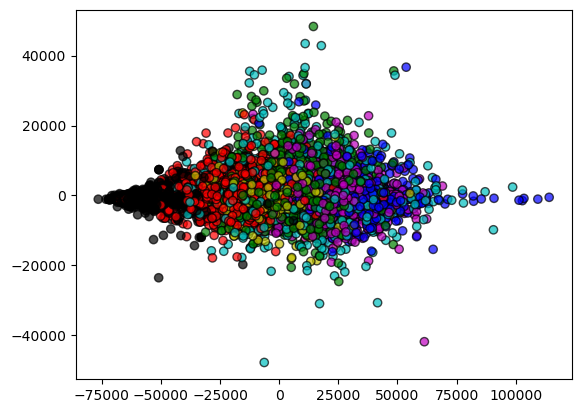

In [37]:
color_map={0:'k', 1:'g', 2:'r', 3:'b', 4:'y', 5:'c', 6:'m', 7:'w'}


y_mapped_kmed = df_ts['kmedoids_labels'].replace(color_map)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mapped_kmed,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.7, linewidths=1)

#plt.scatter(X_tsne[medoids, 0], X_tsne[medoids, 1], marker='*',
#            edgecolor='k', alpha=1, linewidths=2)

plt.show()

In [48]:
#np.save('kmedoids_labels', kmedoids.labels_)

In [49]:
print('Silhouette', silhouette_score(dist_mat_paa, df_ts['kmedoids_labels'], metric='precomputed'))

Silhouette 0.18349920956129645


In [50]:
print('Silhouette', silhouette_score(dist_mat_tot, df_ts['kmedoids_labels'], metric='precomputed'))

Silhouette 0.15869656836942184


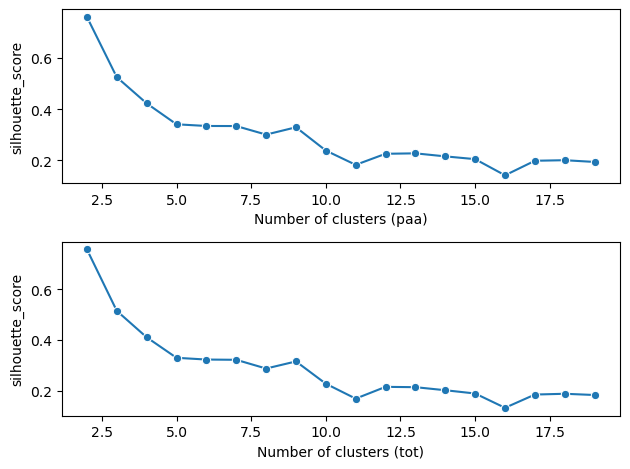

In [72]:
dist_mat_tot = 0.000002*dist_mat_paa + dist_mat_attr

sil_paa = np.zeros(18)
sil_tot = np.zeros(18)

for i in range(2,20):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', metric = 'precomputed').fit(dist_mat_tot)
    sil_paa[i-2] = silhouette_score(dist_mat_paa, kmedoids.labels_, metric='precomputed')
    sil_tot[i-2] = silhouette_score(dist_mat_tot, kmedoids.labels_, metric='precomputed')
    

fig, axs = plt.subplots(2) 

sns.lineplot(x=range(2,len(sil_paa)+2), y=sil_paa, marker='o', ax=axs[0])
axs[0].set(xlabel='Number of clusters (paa)', ylabel='silhouette_score')

sns.lineplot(x=range(2, len(sil_tot)+2), y=sil_tot, marker='o', ax=axs[1])
axs[1].set(xlabel='Number of clusters (tot)', ylabel='silhouette_score')

plt.tight_layout() # Adjust the padding between and around subplots

In [73]:
sil_paa

array([0.76099277, 0.52471924, 0.42222141, 0.34009696, 0.33348914,
       0.33321603, 0.29970981, 0.32841545, 0.23717832, 0.18116536,
       0.22452056, 0.22620608, 0.21435483, 0.2034759 , 0.14014486,
       0.19714759, 0.19932074, 0.19248797])

In [80]:
%%time

dist_mat_attr_man = np.zeros((len(df_merge_clust),len(df_merge_clust)))

for i in range(len(df_merge_clust)):
    for j in range(i+1, len(df_merge_clust)):
        dist_mat_attr_man[i,j] = distance(df_norm[i], df_norm[j], metric="squared")
        dist_mat_attr_man[j,i] = dist_mat_attr_man[i,j]

dist_mat_attr_man

CPU times: user 11min 1s, sys: 14.4 s, total: 11min 15s
Wall time: 11min 13s


array([[ 0.        , 21.90844889, 13.20457967, ..., 39.36377464,
        26.54093789, 18.2998697 ],
       [21.90844889,  0.        ,  7.85743577, ..., 28.56664378,
         9.49833291, 17.18548766],
       [13.20457967,  7.85743577,  0.        , ..., 22.07926431,
         7.90578056,  9.34638909],
       ...,
       [39.36377464, 28.56664378, 22.07926431, ...,  0.        ,
        16.27241871, 27.81407146],
       [26.54093789,  9.49833291,  7.90578056, ..., 16.27241871,
         0.        ,  9.86074654],
       [18.2998697 , 17.18548766,  9.34638909, ..., 27.81407146,
         9.86074654,  0.        ]])

In [90]:
dist_mat_tot_man

array([[  0.        , 158.48744718, 223.14481791, ..., 938.4773655 ,
        727.5144422 , 322.91368058],
       [158.48744718,   0.        , 233.37802551, ..., 866.02248441,
        602.95921475, 279.74304943],
       [223.14481791, 233.37802551,   0.        , ..., 428.19783083,
        428.51156482, 103.89993395],
       ...,
       [938.4773655 , 866.02248441, 428.19783083, ...,   0.        ,
        455.73184648, 559.94650808],
       [727.5144422 , 602.95921475, 428.51156482, ..., 455.73184648,
          0.        , 355.1553668 ],
       [322.91368058, 279.74304943, 103.89993395, ..., 559.94650808,
        355.1553668 ,   0.        ]])

CPU times: user 55.2 s, sys: 10.3 s, total: 1min 5s
Wall time: 1min 6s


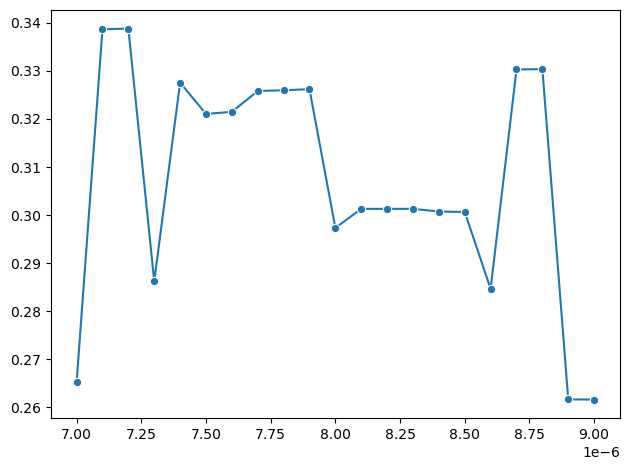

In [159]:
%%time

#tries = [0.000002, 0.0000025, 0.000003, 0.0000075, 0.000008, 0.0000085]
#tries = [0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001]

tries = [0.0000070, 0.0000071, 0.0000072, 0.0000073, 0.0000074, 0.0000075, 0.0000076, 0.0000077, 0.0000078, 
         0.0000079, 0.0000080, 0.0000081, 0.0000082, 0.0000083, 0.0000084, 0.0000085, 0.0000086, 0.0000087, 
         0.0000088, 0.0000089, 0.0000090]


sil_kmed_man = np.zeros(len(tries))
i=0

for t in tries:
    dist_mat_tot_man = t*dist_mat_paa + dist_mat_attr_man
    kmedoids = KMedoids(n_clusters=7, init='k-medoids++', metric = 'precomputed', random_state=13).fit(dist_mat_tot_man)
    sil_kmed_man[i] = silhouette_score(dist_mat_paa, kmedoids.labels_, metric='precomputed')
    i+=1


sns.lineplot(x=tries, y=sil_kmed_man, marker='o')
axs[1].set(xlabel='tries', ylabel='silhouette')


plt.tight_layout() # Adjust the padding between and around subplots

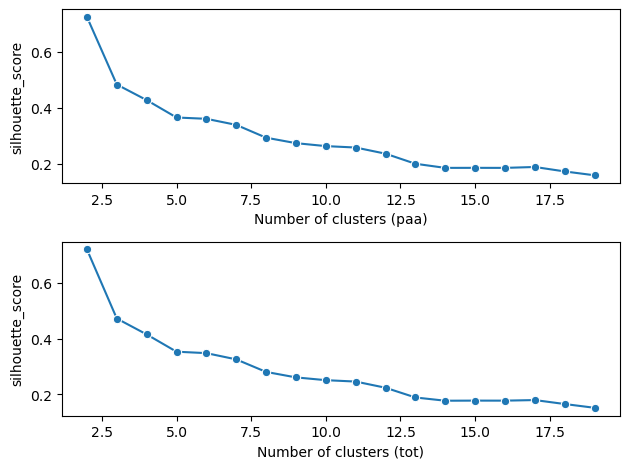

In [160]:
dist_mat_tot_man = 0.0000072*dist_mat_paa + dist_mat_attr_man

sil_paa_man = np.zeros(18)
sil_tot_man = np.zeros(18)

for i in range(2,20):
    kmedoids = KMedoids(n_clusters=i, init='k-medoids++', metric = 'precomputed', random_state=13).fit(dist_mat_tot_man)
    sil_paa_man[i-2] = silhouette_score(dist_mat_paa, kmedoids.labels_, metric='precomputed')
    sil_tot_man[i-2] = silhouette_score(dist_mat_tot_man, kmedoids.labels_, metric='precomputed')
    

fig, axs = plt.subplots(2) 

sns.lineplot(x=range(2,len(sil_paa_man)+2), y=sil_paa_man, marker='o', ax=axs[0])
axs[0].set(xlabel='Number of clusters (paa)', ylabel='silhouette_score')

sns.lineplot(x=range(2, len(sil_tot_man)+2), y=sil_tot_man, marker='o', ax=axs[1])
axs[1].set(xlabel='Number of clusters (tot)', ylabel='silhouette_score')

plt.tight_layout() # Adjust the padding between and around subplots

In [82]:
kmedoids = KMedoids(n_clusters=7, init='k-medoids++', metric = 'precomputed', random_state=13).fit(dist_mat_tot_man)

NameError: name 'dist_mat_tot_man' is not defined

In [162]:
df_ts['kmedoids_labels_man'] = kmedoids.labels_

/var/folders/g7/2_x1m4492lxbbvl9rf481czc0000gn/T/ipykernel_6060/2943163774.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mapped_kmed,


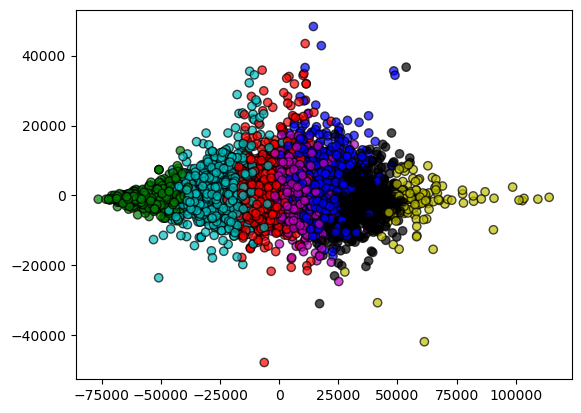

In [163]:
#color_map={0:'k', 1:'g', 2:'r', 3:'b', 4:'y', 5:'c', 6:'m', 7:'w'}


y_mapped_kmed_man = df_ts['kmedoids_labels_man'].replace(color_map)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mapped_kmed,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.7, linewidths=1)

#plt.scatter(X_tsne[medoids, 0], X_tsne[medoids, 1], marker='*',
#            edgecolor='k', alpha=1, linewidths=2)

plt.show()

In [164]:
print('Silhouette', silhouette_score(dist_mat_paa, df_ts['kmedoids_labels_man'], metric='precomputed'))

Silhouette 0.338809172338559


In [165]:
print('Silhouette', silhouette_score(dist_mat_tot_man, df_ts['kmedoids_labels_man'], metric='precomputed'))

Silhouette 0.32536730356027654


In [170]:
dist_mat_attr.mean()

4.150592561419855

In [171]:
dist_mat_tot.mean()

1137.1297510220961

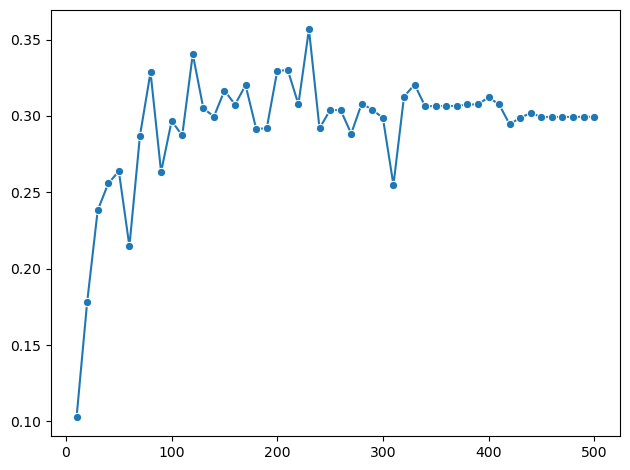

In [75]:
tries = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]
sil_kmed = np.zeros(len(tries))
i=0

for t in tries:
    dist_mat_tot_norm = t*dist_mat_paa_norm + dist_mat_attr_norm
    kmedoids = KMedoids(n_clusters=7, init='k-medoids++', metric = 'precomputed', random_state=13).fit(dist_mat_tot_norm)
    sil_kmed[i] = silhouette_score(dist_mat_paa, kmedoids.labels_, metric='precomputed')
    i+=1


sns.lineplot(x=tries, y=sil_kmed, marker='o')


plt.tight_layout() # Adjust the padding between and around subplots

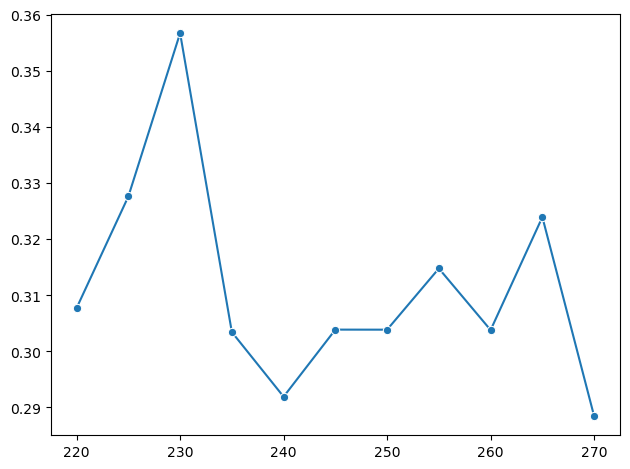

In [78]:
tries = [220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270]
sil_kmed = np.zeros(len(tries))
i=0

for t in tries:
    dist_mat_tot_norm = t*dist_mat_paa_norm + dist_mat_attr_norm
    kmedoids = KMedoids(n_clusters=7, init='k-medoids++', metric = 'precomputed', random_state=13).fit(dist_mat_tot_norm)
    sil_kmed[i] = silhouette_score(dist_mat_paa, kmedoids.labels_, metric='precomputed')
    i+=1


sns.lineplot(x=tries, y=sil_kmed, marker='o')


plt.tight_layout() # Adjust the padding between and around subplots

230 is best

In [81]:
dist_mat_tot_norm = 230*dist_mat_paa_norm + dist_mat_attr_norm

Silhouette 0.28228086964765214
CPU times: user 3.65 s, sys: 1.34 s, total: 4.98 s
Wall time: 5.79 s


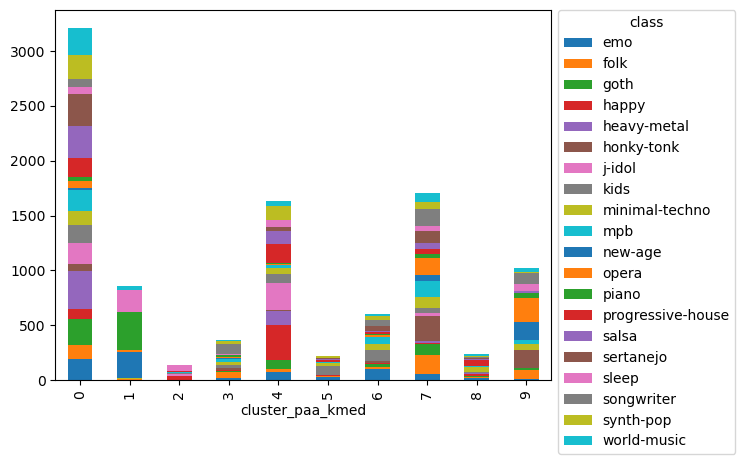

In [94]:
%%time


kmedoids = KMedoids(n_clusters=10, init='k-medoids++', metric = 'precomputed', random_state=13).fit(dist_mat_tot_norm)

print('Silhouette', silhouette_score(dist_mat_paa, kmedoids.labels_, metric='precomputed'))

#my_sse = clusterer.inertia_

df_ts["cluster_paa_kmed"] = kmedoids.labels_
pd.crosstab(df_ts["cluster_paa_kmed"], y).plot(kind="bar", stacked=True)
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', title="class")

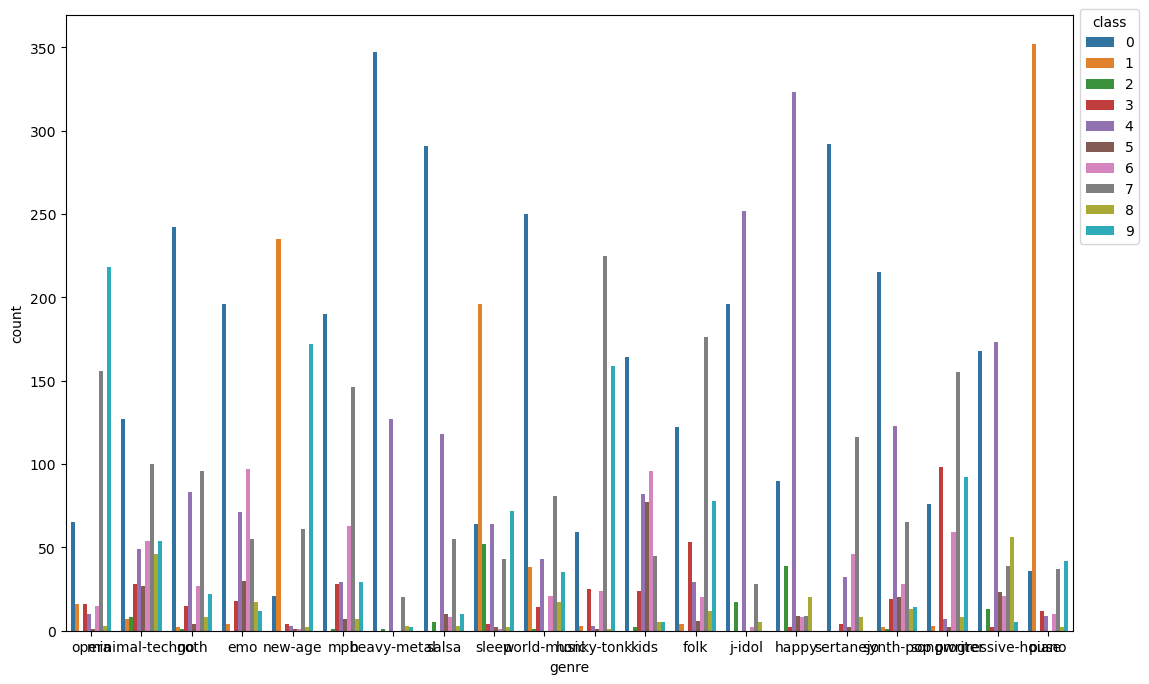

In [96]:
fig = plt.figure(figsize=(13, 8))


sns.countplot(data=df_ts, x='genre', hue='cluster_paa_kmed', )
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left', title="class")
plt.show()

In [90]:
print('Silhouette', silhouette_score(dist_mat_paa, df_ts['cluster_paa_kmed'], metric='precomputed'))

Silhouette 0.3566843432460125


In [91]:
%%time
sse_list = []
sil_list = []


for k in range(2, 30):
    clusterer = KMedoids(n_clusters=k, init='k-medoids++', metric = 'precomputed', random_state=13)
    clusterer.fit(dist_mat_tot_norm)
    sse_list.append(clusterer.inertia_)
    ss = silhouette_score(dist_mat_paa, clusterer.labels_, metric='precomputed')
    sil_list.append(ss)
    print(k, ss)
    if ss < 0.2:
        break

2 0.7419588651016842
3 0.5035311916529019
4 0.4659084808807411
5 0.37751904425284044
6 0.36404223381820644
7 0.3566843432460125
8 0.28965426001621164
9 0.28180639106418814
10 0.28228086964765214
11 0.2816326851871333
12 0.2501459043861119
13 0.2453459316240768
14 0.2347275181580051
15 0.2393885328199739
16 0.23968160643848624
17 0.20394106329893558
18 0.20093320548933363
19 0.17656953388794733
CPU times: user 46.3 s, sys: 5.09 s, total: 51.4 s
Wall time: 54.7 s


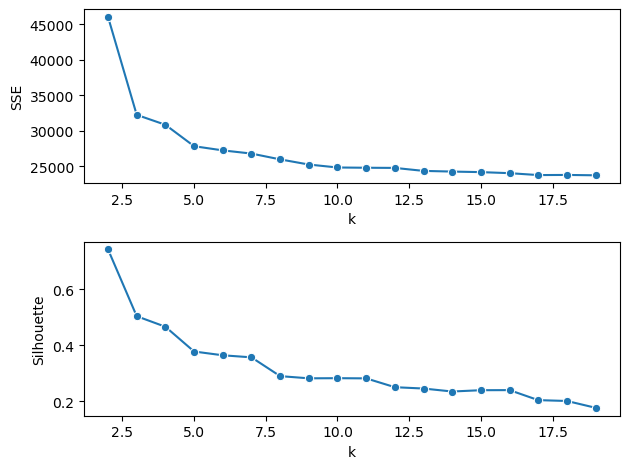

In [92]:
fig, axs = plt.subplots(2) 

sns.lineplot(x=range(2,len(sse_list)+2), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(2, len(sil_list)+2), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots

/var/folders/g7/2_x1m4492lxbbvl9rf481czc0000gn/T/ipykernel_11300/4203076229.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mapped_kmed,


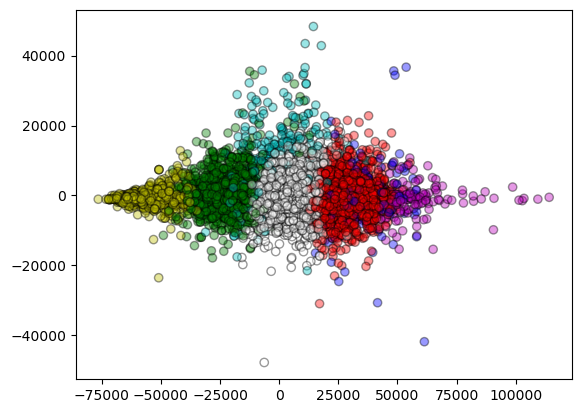

In [93]:
y_mapped_kmed = df_ts['cluster_paa_kmed'].replace(color_map)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_mapped_kmed,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.4, linewidths=1)
#plt.scatter(X_pca[kmedoids.cluster_centers_, 0], X_pca[kmedoids.cluster_centers_, 1], marker='*',
#            edgecolor='k', alpha=1, linewidths=2)
plt.show()

/var/folders/g7/2_x1m4492lxbbvl9rf481czc0000gn/T/ipykernel_11300/3316650767.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_mapped_kmed,


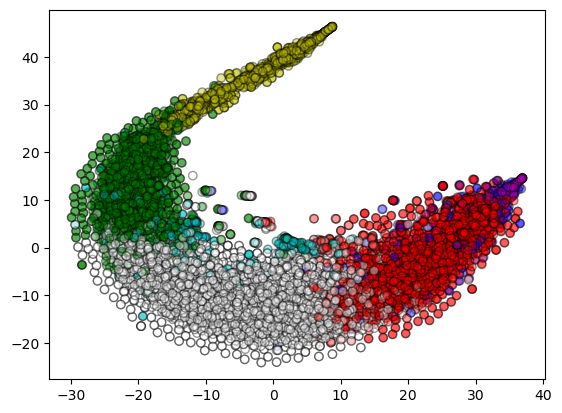

In [86]:
#y_mapped_kmed = df_ts['cluster_paa_kmed'].replace(color_map)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_mapped_kmed,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.4, linewidths=1)
#plt.scatter(X_tsne[kmedoids.cluster_centers_, 0], X_tsne[kmedoids.cluster_centers_, 1], marker='*',
 #           edgecolor='k', alpha=1, linewidths=2)
plt.show()

/var/folders/g7/2_x1m4492lxbbvl9rf481czc0000gn/T/ipykernel_11300/2697451341.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_iso[:, 0], X_iso[:, 1], c=y_mapped_kmed,


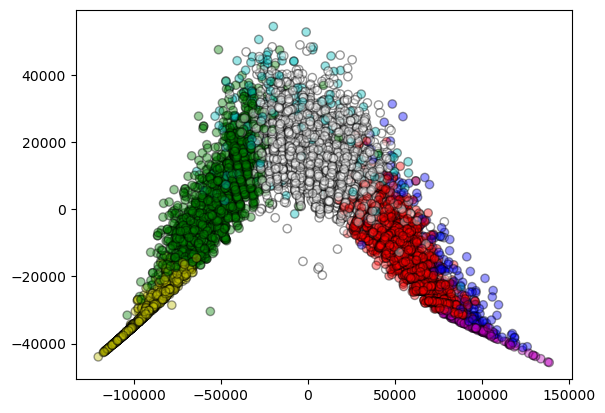

In [87]:
#y_mapped_kmed = df_ts['cluster_paa_kmed'].replace(color_map)

plt.scatter(X_iso[:, 0], X_iso[:, 1], c=y_mapped_kmed,
            cmap=plt.cm.prism, edgecolor='k', alpha=0.4, linewidths=1)
#plt.scatter(X_iso[kmedoids.cluster_centers_, 0], X_iso[kmedoids.cluster_centers_, 1], marker='*',
#            edgecolor='k', alpha=1, linewidths=2)
plt.show()